In [1]:

##This code builds a model to predict sentiments of twitter feed. It uses a dataset with 1.6 million entries for training 
##and LSTM based model using Keras.


#!pip install gensim --upgrade
#!pip install keras --upgrade
#!pip install pandas --upgrade

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from nltk.text import Text
import string, re
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support
from  nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
np.random.seed(1)

Using TensorFlow backend.


In [60]:
#Loading dataset
missing_values = ['na','--','?','-','None','none','non','null','NaN','']
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
X_data= pd.read_csv('training.1600000.processed.noemoticon.csv',encoding="ISO-8859-1",names=DATASET_COLUMNS)


In [61]:
X_data.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
#function to rename emotion numeric values with strings

def train_map(x):
    if x == 0:
        emt = 'NEGATIVE'
    else:
        if x==2:
            emt = 'NEUTRAL'
        else:
            emt = 'POSITIVE'
    
    return emt
    

In [62]:
X_data['target'] = [train_map(x) for x in X_data.target]

In [63]:
X_data.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


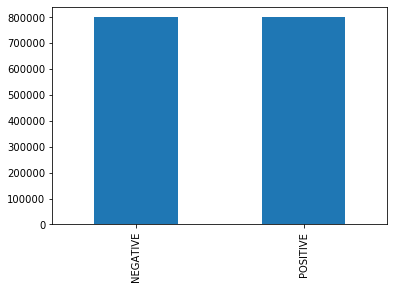

In [8]:
#Histogram plot to see distribution of sentiment values
X_data.target.value_counts().plot(kind='bar')

In [9]:
len(X_data)

1600000

In [10]:
X_data['text'] = X_data.text.str.lower() #changing string to lower case

In [11]:
X_data['text'].head(10)

0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    is upset that he can't update his facebook by ...
2    @kenichan i dived many times for the ball. man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @kwesidei not the whole crew 
6                                          need a hug 
7    @loltrish hey  long time no see! yes.. rains a...
8                 @tatiana_k nope they didn't have it 
9                            @twittera que me muera ? 
Name: text, dtype: object

In [12]:
nltk.download('stopwords')
stop_words = stopwords.words("english") #downloading stopwords in english like 'we','and'


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sacsp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
stemmer = SnowballStemmer("english") #stemmer for to stem words like 'progaram','programme', 'programmer' to the same word 'program'

In [14]:
X_data['text'] = X_data.text.str.replace("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+",' ')
X_data['text'] = X_data.text.str.replace('\d+', ' ') #replace character,weblinks,and numbers by empty spaces


In [15]:
X_data['text'] = X_data.text.str.strip() #removes leading and trailing whitespaces

In [16]:
X_data.head(15)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww that s a bummer you shoulda got david car...
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can t update his facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no it s not behaving at all i m mad why am i h...
5,NEGATIVE,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not the whole crew
6,NEGATIVE,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need a hug
7,NEGATIVE,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains a bit only a bi...
8,NEGATIVE,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope they didn t have it
9,NEGATIVE,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que me muera


In [17]:
#function to remove stop words and apply word stemming
def tokenize(x):
    tokens=[]
    for word in x.split():
        if word not in stop_words:
            tokens.append(stemmer.stem(word))
            
    return " ".join(tokens)

In [18]:

X_data.text = X_data.text.apply(lambda x: tokenize(x))

In [19]:
X_data.text.head(15)


0          awww bummer shoulda got david carr third day
1     upset updat facebook text might cri result sch...
2          dive mani time ball manag save rest go bound
3                       whole bodi feel itchi like fire
4                                         behav mad see
5                                            whole crew
6                                              need hug
7     hey long time see yes rain bit bit lol fine thank
8                                                  nope
9                                             que muera
10                         spring break plain citi snow
11                                            pierc ear
12                 bear watch thought ua loss embarrass
13                   count idk either never talk anymor
14    would first gun realli though zac snyder douch...
Name: text, dtype: object

In [20]:
X_train,X_test = train_test_split(X_data,test_size=0.2, random_state=42) #randomly splitting data into training and test sets

In [21]:
all_text = [line.split() for line in X_data.text] # creating list of tokens for every sentence


In [22]:
model_wv = Word2Vec(size=300,window=7, min_count=1,workers=8) #using Word2Vec to create vocabulary and build a embedding matrix
model_wv.build_vocab(all_text)

In [23]:
print(model_wv)
model_wv.train(all_text,total_examples=len(all_text), epochs=32)

Word2Vec(vocab=271629, size=300, alpha=0.025)


(331912142, 361080000)

In [24]:
words = list(model_wv.wv.vocab) #list of words

In [25]:
model_wv.most_similar("love")

C:\Users\sacsp\Downloads\WPy64-3741\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('amaz', 0.5817209482192993),
 ('luv', 0.5677298903465271),
 ('awesom', 0.5392088890075684),
 ('miss', 0.5303031206130981),
 ('like', 0.46801328659057617),
 ('great', 0.46423783898353577),
 ('lt', 0.4621313810348511),
 ('looov', 0.4519932270050049),
 ('lovee', 0.43340086936950684),
 ('ador', 0.42215511202812195)]

In [33]:
#creating a dictionary to return index for a given word
word_to_index = {}
word_to_index = {val:x+1 for x,val in enumerate(words)}

In [35]:
#creating a dictionary to return word for given index
index_to_word = {x+1:val for x,val in enumerate(words)}

In [36]:
#printing length of vocabulary
len(words)

271629

In [39]:
l_words = [len(x) for x in X_data.text] #finding length of maximum sentence

In [40]:
max_len = max(l_words)

In [43]:
#function to return sentence indices for a given list of sentences, doing pre-padding of zeros to make sure all sentences of same length max_len
#It is important to use pre-padding instead of post-padding for training of different parameters
def sentences_to_indices(Xe,word_to_index,max_len):
    m = Xe.shape[0]
    
    X_indices = np.zeros((m,max_len))
    for i in range(m):
        words = [x for x in Xe[i].split()]
        nw = len(words)
        j=max_len-nw
        for word in words:
            X_indices[i,j] = word_to_index[word]
            j=j+1
        
    return X_indices
            
    

In [45]:
m = X_train.shape[0]

X_indices = np.zeros((m,max_len))
X_text = [x for all x in X_train.text]
X_indices = sentences_to_indices(np.squeeze(X_text),word_to_index,max_len) #converting sentences to indices for training data

vocab_len = len(word_to_index)+1
emb_dim = 300 #dimension of word vectors calculated using Word2Vec
  
emb_matrix = np.zeros((vocab_len,emb_dim))
for word, index in word_to_index.items():   #definining the embedding matrix
    emb_matrix[index] = model_wv.wv[word]




In [46]:
X_indices[0]

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [47]:
#creating model with pre-trained embedding layer
embedding_layer = Embedding(vocab_len, 300, weights=[emb_matrix], input_length=175, trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))


In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 175, 300)          81489000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 175, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 81,649,501
Trainable params: 160,501
Non-trainable params: 81,489,000
_________________________________________________________________


In [57]:
(X_indices.shape)

(1280000, 175)

In [50]:
y_train =np.asarray([0 if x=='POSITIVE' else 1 for x in X_train.target])
y_test = np.asarray([0 if x=='POSITIVE' else 1 for x in X_test.target])  
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("X_train",X_indices.shape)
print("y_train",y_train.shape)
n1 = (y_train==1)
n1 = 1*n1
print(sum(n1))

X_train (1280000, 175)
y_train (1280000,)
640506


In [51]:
y_train[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [52]:
#Training model
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(np.squeeze(X_indices),np.squeeze(y_train), epochs = 5, batch_size = 1024,validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1152000 samples, validate on 128000 samples
Epoch 1/5
1152000/1152000 [==============================] - 10727s 9ms/step - loss: 0.4951 - accuracy: 0.7563 - val_loss: 0.4600 - val_accuracy: 0.7798
Epoch 2/5
1152000/1152000 [==============================] - 9362s 8ms/step - loss: 0.4667 - accuracy: 0.7760 - val_loss: 0.4512 - val_accuracy: 0.7868
Epoch 3/5
1152000/1152000 [==============================] - 9252s 8ms/step - loss: 0.4623 - accuracy: 0.7786 - val_loss: 0.4490 - val_accuracy: 0.7883
Epoch 4/5
1152000/1152000 [==============================] - 9336s 8ms/step - loss: 0.4565 - accuracy: 0.7824 - val_loss: 0.4457 - val_accuracy: 0.7906
Epoch 5/5
1152000/1152000 [==============================] - 9354s 8ms/step - loss: 0.4544 - accuracy: 0.7834 - val_loss: 0.4450 - val_accuracy: 0.7906


In [55]:
#Assessing performance of cross validation set
m = X_test.shape[0]
X_test_indices = np.zeros((m,max_len))
X_test_text = [x for all x in X_test.text]
X_test_indices = sentences_to_indices(np.squeeze(X_test_text),word_to_index,max_len) #converting sentences to indices for training data

score = model.evaluate(X_test_indices, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 821s 3ms/step

ACCURACY: 0.7915156483650208
LOSS: 0.44317375259399416
